<div style='float: right'><img src='pic/kurodoko.png'/></div>

## <div id='kurodoko' />黒どこ

In [1]:
#!pip3 install pulp ortoolpy
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt
from itertools import product
from pulp import *
from ortoolpy import addvar, addvars, addbinvar, addbinvars, unionfind
data = """\
.3.....
.....2.
..5...2
...d...
8...5..
.7.....
.....9.""".split()
nw, nh = len(data[0]), len(data)

### 問題
* 盤面のいくつかのマスを黒くぬります
* 盤面の数字は、その数字から上下左右４方向にまっすぐ進み、次の黒マスか外周にたどりつくまでの、その数字を含めてのマス数の合計を表します
* 数字が入っているマスを黒くぬってはいけません
* 黒マスをタテヨコに連続させたり、黒マスで盤面を分断したりしてはいけません

### 変数
* vb：0: white, 1: black (1)
* vd：0: left, 1: up. 2: right, 3:down (2)

### 制約
* 各マスが黒ならvdは全方向とも0 (3)
* 各マスが白ならvdは方向先のvdより1大きいこと (4)
* 端のvdは、白なら1、黒なら0 (5)
* 黒は連続しないこと (6)
* 数字ならマスは白 (7)
* 数字なら$vd_{ij}$の和は数字＋３に等しいこと (8)
* 黒マスが分断しないこと (9)

CPU times: user 22.6 ms, sys: 5.11 ms, total: 27.7 ms
Wall time: 72.7 ms


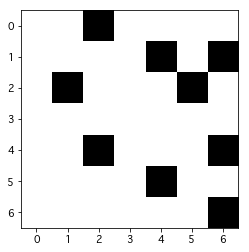

In [2]:
m = LpProblem()
vb = np.array(addbinvars(nh, nw)) # 0: white, 1: black (1)
vd = np.array(addvars(nh, nw, 4)) # 0: left, 1: up. 2: right, 3:down (2)
for i, j in product(range(nh), range(nw)):
    for k in range(4):
        mx = nw if k % 2 else nh
        m += vd[i,j,k] <= (1 - vb[i,j]) * mx # (3)
        ik, jk = i + [-1, 0, 1, 0][k], j + [0, -1, 0, 1][k]
        if 0 <= ik < nh and 0 <= jk < nw:
            m += vd[i,j,k] >= vd[ik,jk,k] + 1 - mx * vb[i,j] # (4)
            m += vd[i,j,k] <= vd[ik,jk,k] + 1 + mx * vb[i,j] # (4)
        else:
            m += vd[i,j,k] == 1 - vb[i,j] # (5)
    if i > 0:
        m += vb[i-1,j] + vb[i,j] <= 1 # (6)
    if j > 0:
        m += vb[i,j-1] + vb[i,j] <= 1 # (6)
    if data[i][j] != '.':
        m += vb[i,j] == 0 # (7)
        n = int(data[i][j]) if data[i][j].isdigit() else ord(data[i][j]) - 87
        m += lpSum(vd[i,j]) == n + 3 # (8)
while True:
    %time m.solve()
    rb = np.vectorize(value)(vb).astype(int)
    if unionfind.isconnected(1-rb):
        break
    m += lpSum(vb[rb==1]) <= rb.sum() - 1 # (9)
plt.imshow(1-rb, cmap='gray', interpolation='none');